<a href="https://colab.research.google.com/github/Mariana-MarquezA/Education-Inequality/blob/main/Education_Inequality_Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of this notebook is to create files with wrangled data. It entails selecting relevant data, structuring raw data to make it ready for analytics, and dealing with missing values through nearest neighbor imputation. We will use the test set approach, thus we will randomly split the clean data, keep 20% as the test set and generate two separate files.

## Import libraries

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno
from google.colab import widgets
from google.colab import output

# Train-test splits and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

## The data

The project utilizes two data sets. The primary data set is the EdGap data set from [EdGap.org](https://www.edgap.org/#5/37.875/-96.987). This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district. The secondary data set is basic information about each school from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp).





### EdGap data

All socioeconomic data (household income, unemployment, adult educational attainment, and family structure) are from the Census Bureau's American Community Survey. 

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) reports that ACT and SAT score data is from each state's department of education or some other public data release. The nature of the other public data release is not known.

The quality of the census data and the department of education data can be assumed to be reasonably high. 

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) do not indicate that they processed the data in any way. The data were assembled by the [EdGap.org](https://www.edgap.org/#5/37.875/-96.987) team, so there is always the possibility for human error. Given the public nature of the data, we would be able to consult the original data sources to check the quality of the data.

### School information data

The school information data is from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). This data set consists of basic identifying information about schools and can be assumed to be of reasonably high quality. As for the EdGap.org data, the school information data is public, so we would be able to consult the original data sources to check the quality of the data.


## Data Load

Load the Edgap and the School_info data sets

In [289]:
# Load the EdGap data set
edgap = pd.read_excel('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/education/EdGap_data.xlsx')

/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [290]:
# Download school_info data set from the dropbox repository 
!wget https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0

--2023-04-25 05:57:10--  https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv [following]
--2023-04-25 05:57:10--  https://www.dropbox.com/s/raw/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18d957497955c0ae0fdd4aedba.dl.dropboxusercontent.com/cd/0/inline/B61LKjfJ3IUi-JdLBe8_2j5yUrDfIUj417yzOuPmM6rQGRf6KK0iRtuJlTuA6R9iqW3M7zmGqbeJ_oipeKez6kPCOZR1uRpOf5qENlnzWTOkLnsexX9Kv7R7KAPUDVDqBPKj52yONtCMSaPUMuCCwBqFbe9h-DepNdQ8-w5qRKA1Sg/file# [following]
--2023-04-25 05:57:11--  https://uc18d957497955c0ae0fdd4aedba.dl.dropboxusercontent.com/cd/0/inline/B61LKjfJ3

In [291]:
# Load the school_info data set
school_info = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding= 'unicode_escape')

<ipython-input-291-b86153ca8fc6>:2: DtypeWarning: Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  school_info = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding= 'unicode_escape')


## Content exploration

Display both dataframes

In [292]:
display(edgap)

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
0,100001...,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008...,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008...,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017...,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018...,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641
...,...,...,...,...,...,...,...
7981,560530...,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156
7982,560569...,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871
7983,560569...,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829
7984,560576...,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583


The edgap data frame contains 'School ACT average (or equivalent if SAT score)'. It will be our independent variable as standarized tests are a measure of educational outcomes. The same data frame contains possible contenders for dependent variables that could help us predict average ACT scores. They all are to some extent socioeconomic factors, thus they are likely related to one another. Later on, it will be important to analyse if any and which of the variables serves better as a proxy for certain socioeconomic phenomena, like inequality.

In [293]:
pd.set_option('display.max_colwidth',10)
display(school_info)

,SCHOOL_YEAR,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,ST_SCHID,NCESSCH,SCHID,MSTREET1,MSTREET2,MSTREET3,MCITY,MSTATE,MZIP,MZIP4,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,PHONE,WEBSITE,SY_STATUS,SY_STATUS_TEXT,UPDATED_STATUS,UPDATED_STATUS_TEXT,EFFECTIVE_DATE,SCH_TYPE_TEXT,SCH_TYPE,RECON_STATUS,OUT_OF_STATE_FLAG,CHARTER_TEXT,CHARTAUTH1,CHARTAUTHN1,CHARTAUTH2,CHARTAUTHN2,NOGRADES,G_PK_OFFERED,G_KG_OFFERED,G_1_OFFERED,G_2_OFFERED,G_3_OFFERED,G_4_OFFERED,G_5_OFFERED,G_6_OFFERED,G_7_OFFERED,G_8_OFFERED,G_9_OFFERED,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,LEVEL,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoy...,Alabam...,1,NaN,AL-210,100002,AL-210...,1.0000...,100277.0,P O Bo...,NaN,NaN,Birmin...,AL,35220,NaN,1000 I...,NaN,NaN,Birmin...,AL,35220,NaN,(205)6...,http:/...,1,Open,1,Open,03/03/...,Altern...,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As rep...
1,2016-2017,1,ALABAMA,AL,Camps,Alabam...,1,NaN,AL-210,100002,AL-210...,1.0000...,101667.0,P O Bo...,NaN,NaN,Mt Meigs,AL,36057,NaN,1601 C...,NaN,NaN,Prattv...,AL,36067,NaN,(334)2...,http:/...,1,Open,1,Open,03/03/...,Altern...,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As rep...
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabam...,1,NaN,AL-210,100002,AL-210...,1.0000...,101670.0,P O Bo...,NaN,NaN,Mt Meigs,AL,36057,NaN,2109 B...,NaN,NaN,Thomas...,AL,36784,NaN,(334)2...,http:/...,1,Open,1,Open,03/03/...,Altern...,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As rep...
3,2016-2017,1,ALABAMA,AL,Wallac...,Alabam...,1,NaN,AL-210,100002,AL-210...,1.0000...,101705.0,P O Bo...,NaN,NaN,Mount ...,AL,36057,NaN,1000 I...,NaN,NaN,Mount ...,AL,36057,NaN,(334)2...,http:/...,1,Open,1,Open,03/03/...,Altern...,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As rep...
4,2016-2017,1,ALABAMA,AL,McNeel...,Alabam...,1,NaN,AL-210,100002,AL-210...,1.0000...,101706.0,8950 R...,NaN,NaN,Birmin...,AL,35206,NaN,8950 R...,NaN,NaN,Birmin...,AL,35206,NaN,(205)8...,http:/...,1,Open,1,Open,03/03/...,Altern...,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As rep...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102178,2016-2017,78,U.S. V...,VI,GLADYS...,Saint ...,1,NaN,VI-001,7800030,VI-001-21,7.8000...,7800025.0,1834 K...,NaN,NaN,Saint ...,VI,802,NaN,68A ES...,NaN,NaN,Saint ...,VI,802,NaN,(340)7...,NaN,1,Open,1,Open,02/27/...,Regula...,1,No,No,Not ap...,NaN,NaN,NaN,NaN,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,KG,06,Elemen...,As rep...
102179,2016-2017,78,U.S. V...,VI,ULLA F...,Saint ...,1,NaN,VI-001,7800030,VI-001-17,7.8000...,7800026.0,1834 K...,NaN,NaN,Saint ...,VI,802,NaN,7B EST...,NaN,NaN,Saint ...,VI,802,NaN,(340)7...,NaN,1,Open,1,Open,02/27/...,Regula...,1,No,No,Not ap...,NaN,NaN,NaN,NaN,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,KG,06,Elemen...,As rep...
102180,2016-2017,78,U.S. V...,VI,YVONNE...,Saint ...,1,NaN,VI-001,7800030,VI-001-23,7.8000...,7800027.0,1834 K...,NaN,NaN,Saint ...,VI,802,NaN,15B an...,NaN,NaN,Saint ...,VI,802,NaN,(340)7...,NaN,1,Open,1,Open,02/27/...,Regula...,1,No,No,Not ap...,NaN,NaN,NaN,NaN,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,KG,06,Elemen...,As rep...
102181,2016-2017,78,U.S. V...,VI,CANCRY...,Saint ...,1,NaN,VI-001,7800030,VI-001-25,7.8000...,7800033.0,1834 K...,NaN,NaN,Saint ...,VI,802,NaN,1 CROW...,NaN,NaN,Saint ...,VI,804,NaN,(340)7...,NaN,1,Open,1,Open,02/27/...,Regula...,1,No,No,Not ap...,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,07,08,Middle,As rep.

The school_info data set is significantly larger than edgap, both in terms of observations and variables. School_info includes detailed information of schools across different states. 

One concern is that school_info includes data for the school cycle 2016-2017 while edgap covers 2016. This difference in time collection of the data can create misleading results. In this case, however, we are studying educational inequality which tends to be structural; thus, it does not vary greatly year from year. Additionally, the time difference may to not be significant as it is a matter of months.

To explore the content of the data sets more closely, let's create summaries.

In [294]:
# Create a table with information of both data sets
grid = widgets.Grid(2, 2, header_row=True, header_column=False)

# Headings
with grid.output_to(0, 0):
  print("edgap.info()")
with grid.output_to(0, 1):  
  print("school_info.info()")

# Information of edgap and school_info
with grid.output_to(1, 0):
  print(edgap.info())
  print(57*'\n')
with grid.output_to(1, 1): 
  print(school_info.info())

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

edgap.info()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

school_info.info()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   int64  
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB
None




























































<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

<IPython.core.display.Javascript object>

In the edgap data set there are missing observations, but not many. However, the school_info data set has School ID's 102181, while edgap only includes 7986. This means that edgap is missing observations by omission.

In general, the school_info data set is quite complete. Nevertheless, there are some columns with few non-null values. Some are due to the nature of the data. For instance, the variable corresponding to the first line of the address ("LSTREET1") is complete, but the ones corresponding to the second ("LSTREET2")and even third line ("LSTREET3"), have less and less values. 

As we will problaly not use all variables of school_info, its null values are not our main concern.

## Data type conversion

Thinking ahead, we will want to join the DataFrames using the identity of the school as the key. The identity is given by the NCESSCH school identity. This has a different name in the two DataFrames, and the value is an `int64` in the EdGap data set and a `float64` in the school information data set.

We will cast the `NCESSCH` column in the `school_info` DataFrame as an `int64`. We first need to drop rows where `NCESSCH` is a `NaN` value. 

In [295]:
school_info = school_info[school_info['NCESSCH'].isna() == False]

In [296]:
school_info.iloc[:, school_info.columns.get_loc('NCESSCH')] = school_info['NCESSCH'].astype('int64')

<ipython-input-296-5510df373f0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info.iloc[:, school_info.columns.get_loc('NCESSCH')] = school_info['NCESSCH'].astype('int64')
<ipython-input-296-5510df373f0c>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  school_info.iloc[:, school_info.columns.get_loc('NCESSCH')] = school_info['NCESSCH'].astype('int64')


In [297]:
# Check data type convertion
print("Data type of school_info['NCESSCH']:", school_info['NCESSCH'].dtype)

Data type of school_info['NCESSCH']: int64


## Are the data suitable for answering the question?

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. If the data are not sufficient, we do not want to waste time doing anything that will not be productive.

We are interested in whether there is a relationship between the ACT score and the socioeconomic variables. We can make scatter plots to get a sense for the data.

Make a pair plot to explore relationships between the variables.

In [298]:
# sns.pairplot(edgap.drop(columns = 'NCESSCH School ID'));

There appears to be a relationship between the socioeconomic variables and the ACT score. We can also see some out-of-range ACT values that will need to be dealt with.

## Data subset

The school information data set contains a lot of information. We only need the year, school identity, location, and school type information.

Keep the columns `SCHOOL_YEAR`, `NCESSCH`, `MSTATE`, `MZIP`, `SCH_TYPE_TEXT`, `LEVEL`

In [299]:
school_info = school_info[['SCHOOL_YEAR', 'NCESSCH', 'MSTATE', 'MZIP', 'SCH_TYPE_TEXT', 'LEVEL']]

In [300]:
display(school_info.head())

,SCHOOL_YEAR,NCESSCH,MSTATE,MZIP,SCH_TYPE_TEXT,LEVEL
0,2016-2017,100002...,AL,35220,Altern...,High
1,2016-2017,100002...,AL,36057,Altern...,High
2,2016-2017,100002...,AL,36057,Altern...,High
3,2016-2017,100002...,AL,36057,Altern...,High
4,2016-2017,100002...,AL,35206,Altern...,High


## Rename columns

In [301]:
edgap = edgap.rename(columns={"NCESSCH School ID":"id", 
              "CT Pct Adults with College Degree":"percent_college",        
              "CT Unemployment Rate":"rate_unemployment", 
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

In [302]:
school_info = school_info.rename(columns={'SCHOOL_YEAR':'year', 
                                          'NCESSCH':'id', 
                                          'MSTATE':'state',
                                          'MZIP':'zip_code',
                                          'SCH_TYPE_TEXT':'school_type',
                                          'LEVEL':'school_level'})

In [303]:
# Display both dataframes to check renaming of columns
pd.set_option('display.max_columns', None)
t = widgets.TabBar(["df_seattle", "df_stlouis"])
with t.output_to(0):
  display(edgap.head())
with t.output_to(1):
  display(school_info.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001...,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008...,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008...,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017...,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018...,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,year,id,state,zip_code,school_type,school_level
0,2016-2017,100002...,AL,35220,Altern...,High
1,2016-2017,100002...,AL,36057,Altern...,High
2,2016-2017,100002...,AL,36057,Altern...,High
3,2016-2017,100002...,AL,36057,Altern...,High
4,2016-2017,100002...,AL,35206,Altern...,High


<IPython.core.display.Javascript object>

## Join data frames 

In [304]:
# Create a table with information of both data sets to check data types
grid = widgets.Grid(2, 2, header_row=True, header_column=False)

# Headings
with grid.output_to(0, 0):
  print("edgap.info()")
with grid.output_to(0, 1):  
  print("school_info.info()")
  
# Information of edgap and school_info
with grid.output_to(1, 0):
  print(edgap.info())
with grid.output_to(1, 1): 
  print(school_info.info())


,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

edgap.info()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

school_info.info()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   int64  
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB
None


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102181 entries, 0 to 102182
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          102181 non-null  object
 1   id            102181 non-null  int64 
 2   state         102181 non-null  object
 3   zip_code      102181 non-null  object
 4   school_type   102179 non-null  object
 5   school_level  102179 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.5+ MB
None


<IPython.core.display.Javascript object>

In [305]:
df = edgap.merge(school_info, how = 'left', on='id')

In [306]:
display(df.head())

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level
0,100001...,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regula...,High
1,100008...,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regula...,High
2,100008...,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regula...,High
3,100017...,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regula...,High
4,100018...,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regula...,High


In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 7985
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   int64  
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
 7   year               7898 non-null   object 
 8   state              7898 non-null   object 
 9   zip_code           7898 non-null   object 
 10  school_type        7898 non-null   object 
 11  school_level       7898 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 811.1+ KB


## Quality Control

In [308]:
df.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
count,7.9860...,7972.0...,7973.0...,7961.0...,7966.0...,7986.0...,7986.0...
mean,3.3218...,0.098730,0.568930,0.633440,52026....,20.181532,0.420651
std,1.3236...,0.058959,0.165704,0.196764,24228....,2.595201,0.239754
min,1.0000...,0.000000,0.091493,0.000000,3589.0...,-3.070818,-0.054545
25%,2.1053...,0.058655,0.450828,0.523810,36597....,18.600000,0.238501
50%,3.6000...,0.085649,0.554979,0.667594,46833....,20.400000,0.381570
75%,4.2266...,0.123376,0.676571,0.777135,61369....,21.910867,0.575447
max,5.6058...,0.590278,1.000000,1.000000,226181...,32.362637,0.998729


ACT SCORES < 1
Because it is a predictor, we will fill it with Nan and get rid of it 

percent-lunch < 0
fill out with nans

In [309]:
df.agg(['min','max']).round(2)

<ipython-input-309-0a3445f9e44c>:1: FutureWarning: ['year', 'state', 'zip_code', 'school_type', 'school_level'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.agg(['min','max']).round(2)


,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
min,100001...,0.00,0.09,0.0,3589.0,-3.07,-0.05
max,560583...,0.59,1.00,1.0,226181.0,32.36,1.00


In [310]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan

In [311]:
df.loc[df['average_act'] < 1, 'average_act'] = np.nan
 # Get rid of the values under 1

In [312]:
counts = df['state'].value_counts()
unique = df['state'].nunique()

print("Value Counts:\n%s \t Unique Values: %s" % (counts, unique))

Value Counts:
TX    966
OH    693
PA    601
IL    590
MI    587
FL    441
NC    416
WI    386
NY    385
GA    383
NJ    354
MO    350
IN    347
TN    309
MA    292
WA    273
LA    245
KY    216
WY     38
DE     26
Name: state, dtype: int64 	 Unique Values: 20


In [313]:
df['school_type'].value_counts()

Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: school_type, dtype: int64

In [314]:
df['school_level'].value_counts()

High            7230
Other            631
Not reported      35
Elementary         2
Name: school_level, dtype: int64

In [315]:
df = df.loc[df['school_level'] == 'High'] # Just take the High school data

## Missing values identification 

In [316]:
df.isna().sum()

id                    0
rate_unemployment    12
percent_college      11
percent_married      20
median_income        16
average_act           3
percent_lunch        20
year                  0
state                 0
zip_code              0
school_type           0
school_level          0
dtype: int64

## Identify missing values

In [317]:
df.isna().sum()

id                    0
rate_unemployment    12
percent_college      11
percent_married      20
median_income        16
average_act           3
percent_lunch        20
year                  0
state                 0
zip_code              0
school_type           0
school_level          0
dtype: int64

In [318]:
df = df.loc[df['average_act'].isna() == False]

In [319]:
df.isna().mean().round(4)*100

id                   0.00
rate_unemployment    0.17
percent_college      0.15
percent_married      0.28
median_income        0.22
average_act          0.00
percent_lunch        0.28
year                 0.00
state                0.00
zip_code             0.00
school_type          0.00
school_level         0.00
dtype: float64

There are some schools that are missing all four of the socioeconomic variables. However, many of the schools are missing only a subset of the variables. If we drop rows that have `NaNs`, then we will negatively affect our analysis using the variables where data were present. So, we will not drop the rows in this data set that are missing the socioeconomic variables. 

We will, however, drop the rows where the average ACT score is missing.

We will impute the remaining missing values after splitting the data into training and testing sets for model evaluation.

get rid off elementary schools, other, and not reported 

Linear models have coeffients with linear relonships with the variable.

Exam policy. Some states require all students to take it, other don't 

<Axes: >

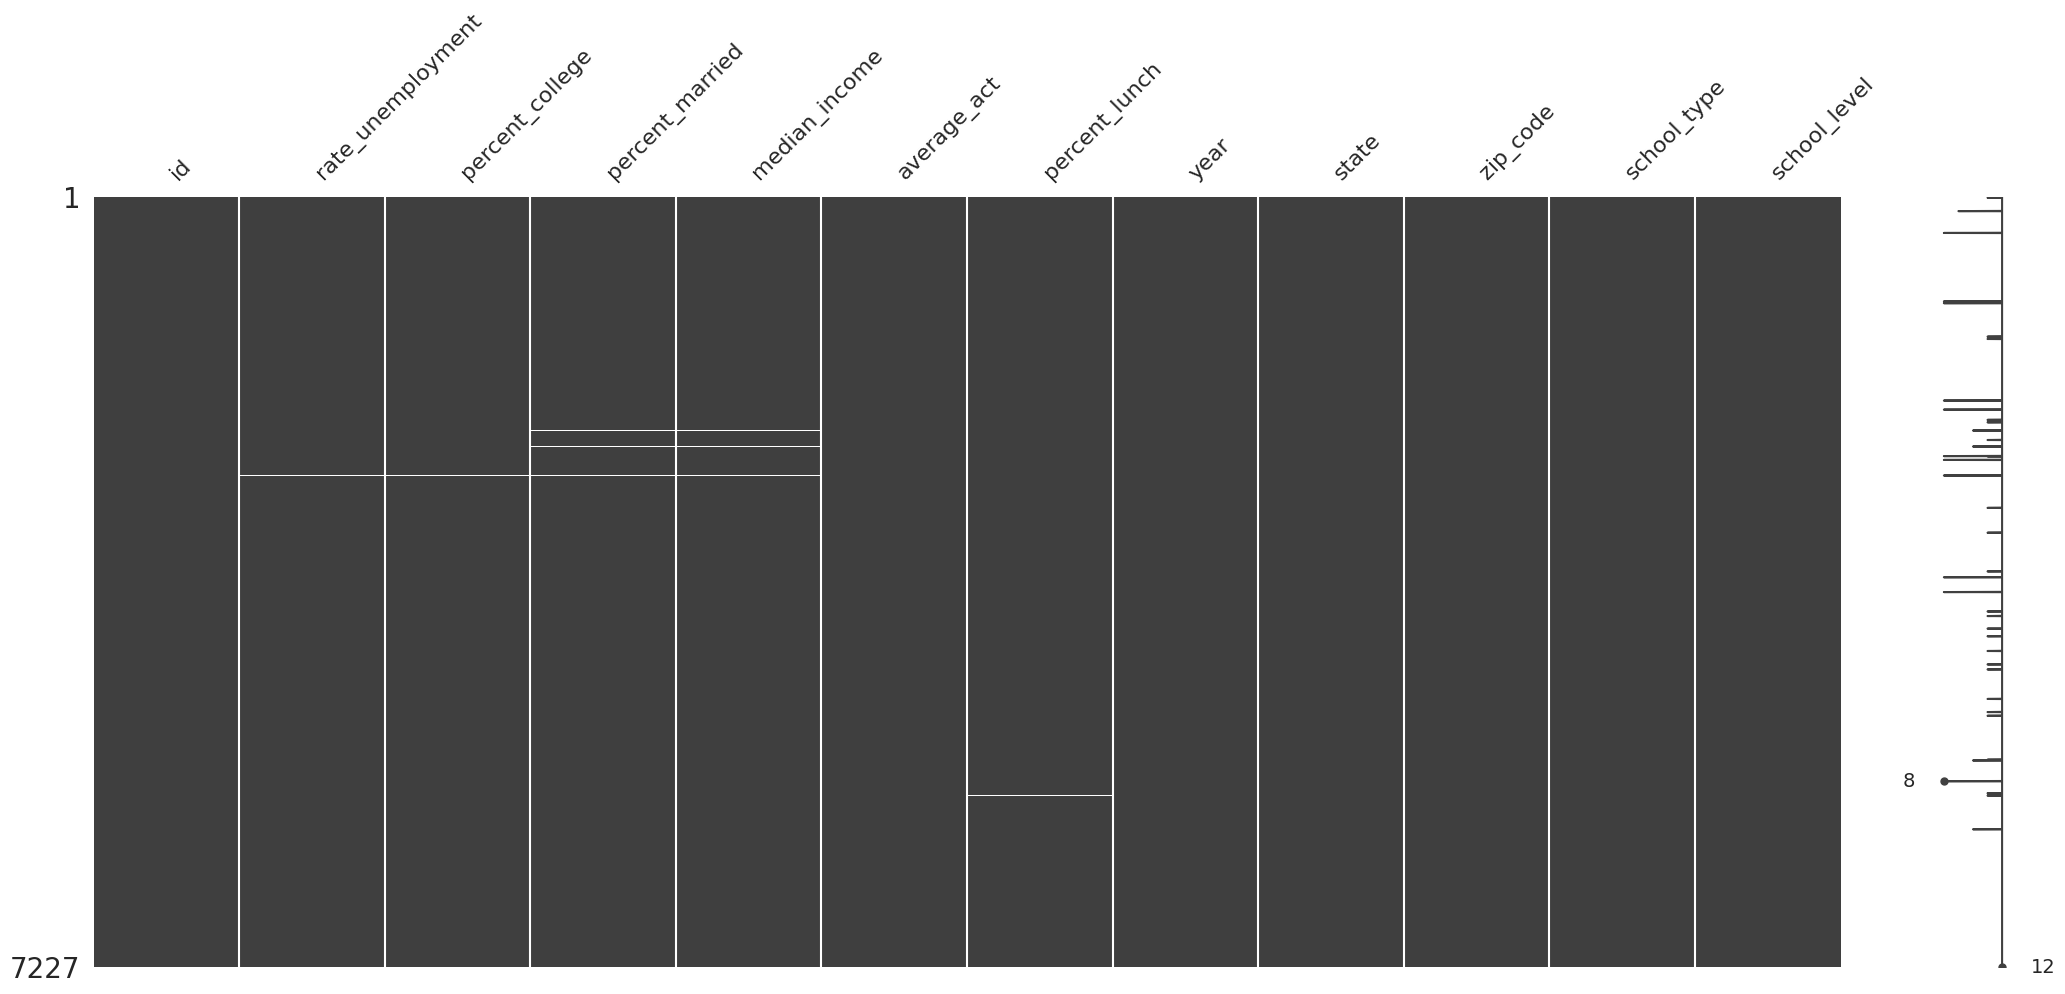

In [320]:
msno.matrix(df)

## Train test split

In [321]:
X = df[df.columns.difference(['id','average_act'])]
y = df['average_act']

In [322]:
X.head()

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code
0,42820.0,0.445283,0.066901,0.346495,0.117962,High,Regula...,DE,2016-2017,19804
1,89320.0,0.662765,0.112412,0.767619,0.063984,High,Regula...,DE,2016-2017,19709
2,84140.0,0.701864,0.096816,0.713090,0.056460,High,Regula...,DE,2016-2017,19709
3,56500.0,0.692062,0.296960,0.641283,0.044739,High,Regula...,DE,2016-2017,19958
4,54015.0,0.640060,0.262641,0.834402,0.077014,High,Regula...,DE,2016-2017,19934


In [323]:
y.head()

0    20.433455
1    19.498168
2    19.554335
3    17.737485
4    18.245421
Name: average_act, dtype: float64

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [325]:
print(X_train.shape, X_test.shape)

(5781, 10) (1446, 10)


In [326]:
X_train.agg(['mean','std']).round(2)

<ipython-input-326-f4b4e74f3eba>:1: FutureWarning: ['school_level', 'school_type', 'state', 'year', 'zip_code'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  X_train.agg(['mean','std']).round(2)


,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
mean,52829.04,0.57,0.41,0.64,0.10
std,24438.45,0.17,0.23,0.19,0.06


In [327]:
X_test.agg(['mean','std']).round(2)

<ipython-input-327-247411c871de>:1: FutureWarning: ['school_level', 'school_type', 'state', 'year', 'zip_code'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  X_test.agg(['mean','std']).round(2)


,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
mean,52540.40,0.57,0.41,0.64,0.10
std,24074.71,0.16,0.24,0.20,0.06


#### Imputation

In [328]:
#imputer = KNNImputer()
imputer = IterativeImputer()

In [329]:
# Define the features `X` that will be used to impute missing values.
imputer.fit(X_train.loc[:, 'median_income':'rate_unemployment'] )

IterativeImputer()

In [330]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5781 entries, 306 to 28
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_income      5768 non-null   float64
 1   percent_college    5773 non-null   float64
 2   percent_lunch      5764 non-null   float64
 3   percent_married    5765 non-null   float64
 4   rate_unemployment  5772 non-null   float64
 5   school_level       5781 non-null   object 
 6   school_type        5781 non-null   object 
 7   state              5781 non-null   object 
 8   year               5781 non-null   object 
 9   zip_code           5781 non-null   object 
dtypes: float64(5), object(5)
memory usage: 496.8+ KB


In [331]:
X_train.loc[:, 'median_income':'rate_unemployment'] = imputer.transform(X_train.loc[:,'median_income':'rate_unemployment'])

In [332]:
X_train.isna().sum()

median_income        0
percent_college      0
percent_lunch        0
percent_married      0
rate_unemployment    0
school_level         0
school_type          0
state                0
year                 0
zip_code             0
dtype: int64

In [333]:
X_test.isna().sum()

median_income        3
percent_college      3
percent_lunch        3
percent_married      4
rate_unemployment    3
school_level         0
school_type          0
state                0
year                 0
zip_code             0
dtype: int64

In [334]:
X_test.loc[:,'median_income':'rate_unemployment'] = imputer.transform(X_test.loc[:,'median_income':'rate_unemployment'])

In [335]:
X_test.isna().sum()

median_income        0
percent_college      0
percent_lunch        0
percent_married      0
rate_unemployment    0
school_level         0
school_type          0
state                0
year                 0
zip_code             0
dtype: int64

In [336]:
df_train = X_train.join(y_train)

In [337]:
df_train.head()

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act
306,39018.0,0.506103,0.259748,0.357143,0.077797,High,Regula...,FL,2016-2017,32548,22.667888
5990,46587.0,0.652605,0.247803,0.452163,0.053510,High,Regula...,PA,2016-2017,18643,20.274725
3347,40465.0,0.348819,0.456140,0.760316,0.042316,High,Regula...,MO,2016-2017,65542,21.300000
2182,55469.0,0.352850,0.699205,0.703807,0.047319,High,Regula...,LA,2016-2017,70755,18.000000
5124,43053.0,0.173913,0.118568,0.991053,0.020845,High,Regula...,OH,2016-2017,44610,23.000000


In [338]:
df_test = X_test.join(y_test)

In [340]:
from google.colab import files

df_train.to_csv('clean_df_train.csv', encoding = 'utf-8-sig', index=False) 

files.download('clean_df_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [341]:
df_test.to_csv('clean_df_test.csv', encoding = 'utf-8-sig', index=False) 

files.download('clean_df_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>